# Template Demonstration

We demonstrate fitting the RR Lyrae templates to SDSS and DES light curves. We access the R fitting functions through the `rpy2` package in Python. See demo_R.R for more examples.

In [1]:
## python demo of RR Lyrae template fitter fit_template.R
## by james long
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.vectors import IntVector, FloatVector, StrVector, BoolVector
import rpy2.robjects.numpy2ri as rpyn
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')
import itertools

## set up rpy2 so we can call R functions
r=robjects.r
r.source("fit_template.R")
r.load("template_sdss.RData") ## loads r.tem, see later code for usage
FitTemplate=robjects.r['FitTemplate']
ComputeCoeffs=robjects.r['ComputeCoeffs']


In [2]:
###### load an SDSS RR Lyrae

## load a light curve, put in nice format
fname="LC_402316.dat"
with open(fname) as csvf:
    f = csv.reader(csvf,delimiter=' ')
    time, band, mag, error = zip(*f)

## removes flagged observations
no_pound = [not '#' in x for x in time]    
time = list(itertools.compress(time, no_pound))
band = list(itertools.compress(band, no_pound))
mag = list(itertools.compress(mag, no_pound))
error = list(itertools.compress(error, no_pound))


time = np.array(time,dtype='float64')
mag = np.array(mag,dtype='float64')
error = np.array(error,dtype='float64')




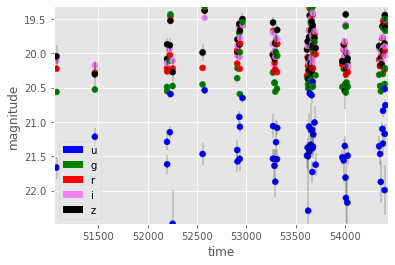

In [3]:
######## plot unfolded (raw light curve)
cols = {'u': 'blue', 'g': 'green', 'r':'red', 'i':'violet', 'z':'black'}
plt.errorbar(time, mag, yerr=error, fmt=' ',alpha=0.2,color='black')
pts = plt.scatter(time,mag,color=list(map(cols.get,band)))
##plt.gca().invert_yaxis()
plt.xlim([np.min(time)-30,np.max(time)+30])
plt.ylim([np.max(mag),np.min(mag)])
recs = []
for i in cols.values():
    recs.append(mpatches.Rectangle((0,0),1,1,fc=i))

plt.xlabel("time")
plt.ylabel("magnitude")
plt.legend(recs,cols.keys(),loc=3)

plt.show()

## Demo 1: Fit well sampled light curve with dust parameter ON 

In [5]:
## create R dataframe using time,band,mag,error
lc = robjects.r['TBMEtoLC'](FloatVector(time),StrVector(band),FloatVector(mag),FloatVector(error))

# ###### fit model to lc
## choose frequency grid
omegas=FloatVector(np.arange(start=1.0,stop=2.5,step=0.1/4000.0))
## compute rss (residual sum of squares) for each frequency, takes a minute
rss=FitTemplate(lc,omegas,r.tem_sdss)
## select best fitting period, ie lowest rss
omega = omegas[np.argmin(rss).item()] ## best fit frequency
pest=1.0/omega ## best fit period
coeffs=ComputeCoeffs(lc,omega,r.tem_sdss) ## parameter estimates of best fit frequency
## the output is [distance modulus (mu),amount of dust (E[B-V]),amplitude (a),phase (rho)]
# >>> coeffs
# R object with classes: ('numeric',) mapped to:
# <FloatVector - Python:0x7f6ecca62088 / R:0x6c3bcf0>
# [19.250568, 0.044055, 1.225825, 0.172240]
# >>> omega
# 1.8413499999980392
# >>> pest
# 0.543079805578008

In [6]:
print("period estimate: " + str(pest))
print("(distance modulus,E[B-V],amplitude,phase) estimate: \n" + str(coeffs))

period estimate: 0.543079805578008
(distance modulus,E[B-V],amplitude,phase) estimate: 
[1] 19.25056816  0.04405524  1.22582462  0.17224036



With well sampled light curves it is easy to visually check that we obtained the correct period.

/Users/jplong/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
/Users/jplong/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
/Users/jplong/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
/Users/jplong/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will t

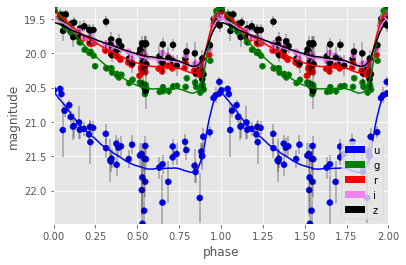

In [19]:
## plot lightcurve folded on estimated period
mag2 = np.array((mag,mag)).reshape(mag.size*2)
error2 = np.array((error,error)).reshape(error.size*2)
phase = np.mod(time + coeffs[3]*pest,pest)/pest
phase2 = np.array((phase,phase+1.0)).reshape(phase.size*2)
cc = list(map(cols.get,band))
cc.extend(cc)
pts=plt.scatter(phase2,mag2,color=cc)
plt.errorbar(phase2, mag2, yerr=error2, fmt=' ',alpha=0.3,color='black')
plt.xlim([0,2.0])
recs = []
for i in cols.values():
    recs.append(mpatches.Rectangle((0,0),1,1,fc=i))

plt.legend(recs,cols.keys(),loc=4)

### add template fits manually
gamma = r.tem_sdss[1]
gamma = np.resize(gamma,(5,100))
t=(np.arange(100)/100.)
t2 = np.array((t,t+1)).reshape(t.size*2)
abs_mag = r.tem_sdss[7](pest,r.tem_sdss) ## get absolute magnitudes at pest
for ii in np.arange(gamma.shape[0]):
    m=coeffs[0] + abs_mag[ii.item()] + r.tem_sdss[0][ii.item()]*coeffs[1] + coeffs[2]*gamma[ii.item(),:]
    m2 = np.array((m,m)).reshape(2*m.size)
    plt.plot(t2,m2,'k',color=cols[r.tem_sdss[0].names[ii.item()]])



plt.gca().invert_yaxis()
plt.legend(recs,cols.keys(),loc=4)
    
    

plt.ylim([np.max(mag),np.min(mag)])

plt.xlabel("phase")
plt.ylabel("magnitude")
    
plt.show()



Plot the RSS (weighted residual sum of squares) as a function of frequency. This is similar to an inverse periodogram, with lower values indicating better fit. Roughly speaking, the period significance is high if the global minimum is well separated from all local min.

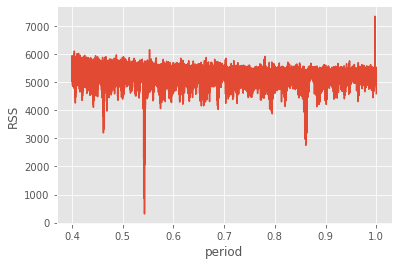

In [20]:
plt.plot(1.0/np.asarray(omegas),np.asarray(rss))
#plt.xlim(1.0,2.5)
plt.xlabel("period")
plt.ylabel("RSS")
plt.show()


## Demo 2: Dust OFF

We can estimate dust from dust maps and subtract this off light curves. The RR Lyrae model can then be fit without dust. This has two advantages:
* One less parameter to fit results in less uncertainty in parameter estimates and greater chance of estimating period correctly. Mostly helpful for poorly sampled light curves.
* Extinction due to dust and distance are highly correlated so removing dust usually improves distance estimates. We see decreases from 10% scatter to 3% scatter in distance for poorly sampled light curves.

In [21]:
###### DUST CORRECT LIGHT CURVE AND FIT MODEL
###### WITHOUT DUST
###### obtain dust from schlegel dust map

## load a light curve, put in nice format
fname="LC_402316.dat"
with open(fname) as csvf:
    f = csv.reader(csvf,delimiter=' ')
    time, band, mag, error = zip(*f)

no_pound = [not '#' in x for x in time]    
time = list(itertools.compress(time, no_pound))
band = list(itertools.compress(band, no_pound))
mag = list(itertools.compress(mag, no_pound))
error = list(itertools.compress(error, no_pound))

## convert to floats
mag = list(map(float,mag))
time = list(map(float,time))
error = list(map(float,error))

## dust correct mag vector
schlegel_r = 0.108 ## extinction in r reported by schlegel for this RA / DEC
dust_dict = {list(r.tem_sdss[0].names)[i] : list(r.tem_sdss[0])[i] for i in range(5)}
ebv = schlegel_r / dust_dict['r'] ## convert to ebv

def DustCorrect(b,m): ## b is band, m is mag
    return m - ebv*dust_dict[b]

mag = list(map(DustCorrect, band, mag))


In [22]:
## create R dataframe using time,band,mag,error
time = np.array(time,dtype='float64')
mag = np.array(mag,dtype='float64')
error = np.array(error,dtype='float64')
lc = robjects.r['TBMEtoLC'](FloatVector(time),StrVector(band),FloatVector(mag),FloatVector(error))



In [24]:

### fit model to lc with dust turned OFF
omegas=FloatVector(np.arange(start=1.0,stop=2.5,step=0.1/4000.0))
NN = IntVector(np.array([5],dtype='int'))
use_errors = BoolVector(np.array([True],dtype='bool'))
use_dust = BoolVector(np.array([False],dtype='bool'))
rss=FitTemplate(lc,omegas,r.tem_sdss,NN,use_errors,use_dust)
## select best fitting period, ie lowest rss
omega = omegas[np.argmin(rss).item()] ## best fit frequency
pest=1.0/omega ## best fit period
NN = IntVector(np.array([20],dtype='int'))
coeffs=ComputeCoeffs(lc,omega,r.tem_sdss,NN,use_errors,use_dust)  ## parameter estimates of best fit frequency
print(coeffs)
## the output is [distance modulus (mu),amount of dust (E[B-V]),amplitude (a),phase (rho)]
## E[B-V] = 0 because dust is off
# >>> coeffs
# R object with classes: ('numeric',) mapped to:
# <FloatVector - Python:0x7fad945a1ac8 / R:0x65cef18>
# [19.256907, 0.000000, 1.225244, 0.172226]
print(omega)
# >>> omega
# 1.8413499999980392
print(pest)
# >>> pest
# 0.543079805578008


[1] 19.256907  0.000000  1.225244  0.172226

1.8413499999980392
0.543079805578008


## Demo 3: Fit DES Templates

The star used in the earlier demos `LC_402316.dat` was observed by SDSS. This RR Lyrae was also observed by DES, but with a much sparser cadence. We use the DES template to estimate the period on this sparsely sampled light curve and confirm that is estimates the period accurately.

In [25]:
###### FIT MODEL on DES version of light curve
#### compare sloan / des fits on same RRL
r.load("template_des.RData") ## loads des template


## load des light curve, put in nice format
fname="LC_402316_des.dat"
with open(fname) as csvf:
    f = csv.reader(csvf,delimiter='\t')
    next(f,None)
    time, mag, error, band = zip(*f)

## get rid of suspicious data containing #
no_pound = [not '#' in x for x in time]    
time = list(itertools.compress(time, no_pound))
band = list(itertools.compress(band, no_pound))
mag = list(itertools.compress(mag, no_pound))
error = list(itertools.compress(error, no_pound))


time = np.array(time,dtype='float64')
mag = np.array(mag,dtype='float64')
error = np.array(error,dtype='float64')


## create R dataframe using time,band,mag,error
lc = robjects.r['TBMEtoLC'](FloatVector(time),StrVector(band),FloatVector(mag),FloatVector(error))

Plot sparsely sampled DES light curve.

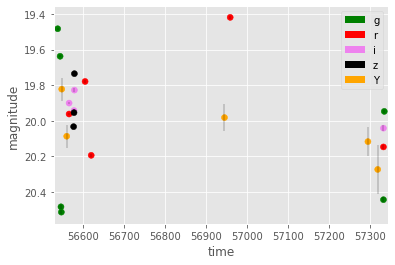

In [26]:
cols = {'g': 'green', 'r':'red', 'i':'violet', 'z':'black', 'Y':'orange'}
plt.errorbar(time, mag, yerr=error,fmt=' ',alpha=0.2,color='black')
plt.scatter(time,mag,color=list(map(cols.get,band)))
plt.gca().invert_yaxis()
plt.xlim([np.min(time)-10,np.max(time)+10])
recs = []
for i in cols.values():
    recs.append(mpatches.Rectangle((0,0),1,1,fc=i))


plt.legend(recs,cols.keys(),loc=1)
plt.xlabel("time")
plt.ylabel("magnitude")

plt.show()

In [28]:
rss_des=FitTemplate(lc,omegas,r.tem_des)
## select best fitting period, ie lowest rss
omega_des = omegas[np.argmin(rss_des).item()] ## best fit frequency
## parameter estimates of best fit frequency, compare to sloan above
pest_des=1.0/omega_des ## best fit period
coeffs_des=ComputeCoeffs(lc,omega_des,r.tem_des) 
# >>> coeffs_des
# R object with classes: ('numeric',) mapped to:
# <FloatVector - Python:0x7fad945a9808 / R:0x5171668>
# [19.232691, 0.049118, 1.182909, 0.182078]
pest_des

0.543079805578008

In [29]:
coeffs_des[3]

0.18207794139743783

Plot folded light curve.

/Users/jplong/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
/Users/jplong/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
/Users/jplong/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
/Users/jplong/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will t

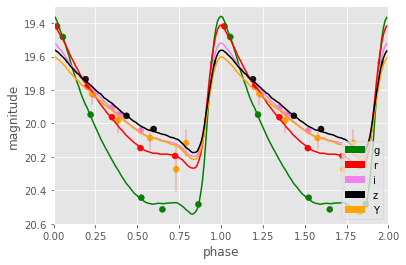

In [32]:
## plot lightcurve folded on estimated period
mag2 = np.array((mag,mag)).reshape(mag.size*2)
error2 = np.array((error,error)).reshape(error.size*2)
phase = np.mod(time + coeffs_des[3]*pest_des,pest_des)/pest_des
phase2 = np.array((phase,phase+1.0)).reshape(phase.size*2)
cc = list(map(cols.get,band))
cc.extend(cc)
pts=plt.scatter(phase2,mag2,color=cc)
plt.errorbar(phase2, mag2, yerr=error2, fmt=' ',alpha=0.3)

plt.xlim([0.,2.])
recs = []
for i in cols.values():
    recs.append(mpatches.Rectangle((0,0),1,1,fc=i))

### add template fits manually
gamma = r.tem_des[1]
gamma = np.resize(gamma,(5,100))
t=(np.arange(100)/100.)
t2 = np.array((t,t+1)).reshape(t.size*2)

#ords=np.argsort((t - coeffs_des[3]*pest_des) % pest_des)
abs_mag = r.tem_des[7](pest_des,r.tem_des) ## get absolute magnitudes at pest
for ii in np.arange(gamma.shape[0]):
    m=coeffs_des[0] + abs_mag[ii.item()] + r.tem_des[0][ii.item()]*coeffs_des[1] + coeffs_des[2]*gamma[ii.item(),:]
    m2 = np.array((m,m)).reshape(2*m.size)
    plt.plot(t2,m2,'k',color=cols[r.tem_des[0].names[ii.item()]])

plt.ylim([19.3,20.6])
plt.gca().invert_yaxis()
plt.legend(recs,cols.keys(),loc=4)

plt.xlabel("phase")
plt.ylabel("magnitude")
    
plt.show()



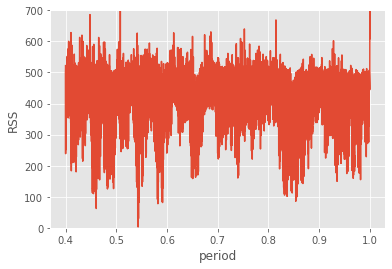

In [33]:
plt.plot(1.0/np.asarray(omegas),np.asarray(rss_des))
plt.ylim(0,700)
plt.xlabel("period")
plt.ylabel("RSS")
plt.show()


In [34]:
######## compare des and sloan estimates
print("des period estimate: " + str(pest_des))
print("SDSS period estimate: " + str(pest))

des period estimate: 0.543079805578008
SDSS period estimate: 0.543079805578008
